# Introdução às Redes Convolucionais com PyTorch

Neste notebook, vamos explorar Redes Neurais usando a biblioteca PyTorch. Vamos começar com uma Rede Neural Totalmente Conectada (Fully Connected Network) para classificar dígitos do dataset MNIST. Em seguida, substituiremos a rede por uma Rede Neural Convolucional (CNN) e compararemos os resultados.

## Objetivos
- Carregar e preprocessar o dataset MNIST.
- Implementar uma Rede Neural Totalmente Conectada.
- Treinar e avaliar a rede.
- Substituir a rede por uma CNN e comparar os resultados.

In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
# from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## Carregando e Preprocessando o Dataset MNIST

O dataset MNIST contém 60.000 imagens de treinamento e 10.000 imagens de teste de dígitos manuscritos, de 0 a 9.

In [2]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-08-18 20:42:59--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  33.5MB/s    in 3.1s    

2024-08-18 20:43:03 (33.5 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [5]:
# Criando índices aleatórios para os subsets de treino e teste
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

train_indices = indices[:10000]  # Primeiros 10.000 índices para o trainset
test_indices = indices[10000:11000]  # Próximos 1.000 índices para o testset

trainset = Subset(mnist_dataset, train_indices)
testset = Subset(mnist_dataset, test_indices)

In [6]:
# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

## Visualizando Algumas Imagens do Dataset

Vamos visualizar algumas imagens do dataset de treino para entender melhor os dados com os quais estamos trabalhando.

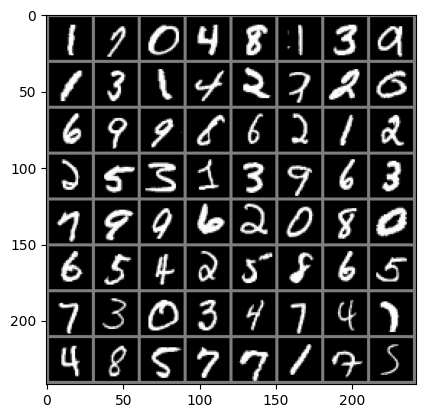

In [7]:
# Função para mostrar uma imagem
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Obter algumas imagens de treinamento
images, labels = next(iter(trainloader))

# Mostrar imagens
imshow(torchvision.utils.make_grid(images))
# Mostrar labels
print('Labels: ', ' '.join('%d' % labels[j] for j in range(8)))

In [8]:
def train_model(model, trainloader, criterion, optimizer, num_epochs=5):
    train_losses = []
    accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            # Obter os inputs; data é uma lista de [inputs, labels]
            inputs, labels = data

            # Zerar os gradientes dos parâmetros otimizados
            optimizer.zero_grad()

            # forward + backward + otimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Estatísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 50 == 49:
                train_losses.append(running_loss / 100)
                running_loss = 0.0

        epoch_acc = 100 * correct / total
        accuracies.append(epoch_acc)
        print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.3f}, Accuracy: {epoch_acc:.2f}%')
    print('Treinamento concluído')
    return train_losses, accuracies


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Definindo a Rede Neural Totalmente Conectada

Vamos definir uma arquitetura simples de Rede Neural Totalmente Conectada (FCN).

In [9]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

fcn_model = FCN()

Labels:  1 7 0 4 8 1 3 9


In [10]:
fcn_params = count_parameters(fcn_model)
print(f"Total de parâmetros na FCN: {fcn_params}")

Total de parâmetros na FCN: 109386


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcn_model.parameters(), lr=0.01, momentum=0.9)

In [12]:
# Treinando a FCN
fcn_losses, fcn_accuracies = train_model(fcn_model, trainloader, criterion, optimizer)

100%|██████████| 157/157 [00:08<00:00, 17.95it/s]


Epoch 1, Loss: 0.253, Accuracy: 67.87%


100%|██████████| 157/157 [00:09<00:00, 16.71it/s]


Epoch 2, Loss: 0.191, Accuracy: 87.55%


100%|██████████| 157/157 [00:09<00:00, 16.52it/s]


Epoch 3, Loss: 0.155, Accuracy: 90.08%


100%|██████████| 157/157 [00:08<00:00, 18.15it/s]


Epoch 4, Loss: 0.127, Accuracy: 92.18%


100%|██████████| 157/157 [00:08<00:00, 19.09it/s]

Epoch 5, Loss: 0.102, Accuracy: 93.54%
Treinamento concluído


In [13]:
# Testando a FCN
test_model(fcn_model, testloader)

Acurácia da rede na base de teste: 92.40%


## Substituindo a Rede Neural por uma CNN

Agora, vamos substituir a Rede Neural Totalmente Conectada por uma Rede Neural Convolucional (CNN) e comparar os resultados.

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

cnn_model = CNN()

In [15]:
cnn_params = count_parameters(cnn_model)
print(f"Total de parâmetros na CNN: {cnn_params}")

Total de parâmetros na CNN: 14970


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

In [17]:
# Treinando a CNN
cnn_losses, cnn_accuracies = train_model(cnn_model, trainloader, criterion, optimizer)

100%|██████████| 157/157 [00:09<00:00, 16.66it/s]


Epoch 1, Loss: 0.217, Accuracy: 63.40%


100%|██████████| 157/157 [00:08<00:00, 18.70it/s]


Epoch 2, Loss: 0.102, Accuracy: 92.76%


100%|██████████| 157/157 [00:08<00:00, 17.92it/s]


Epoch 3, Loss: 0.074, Accuracy: 95.39%


100%|██████████| 157/157 [00:09<00:00, 16.85it/s]


Epoch 4, Loss: 0.051, Accuracy: 96.63%


100%|██████████| 157/157 [00:08<00:00, 17.46it/s]

Epoch 5, Loss: 0.042, Accuracy: 97.32%
Treinamento concluído


In [18]:
# Testando a CNN
test_model(cnn_model, testloader)

Acurácia da rede na base de teste: 97.00%


## Comparando as duas redes neurais

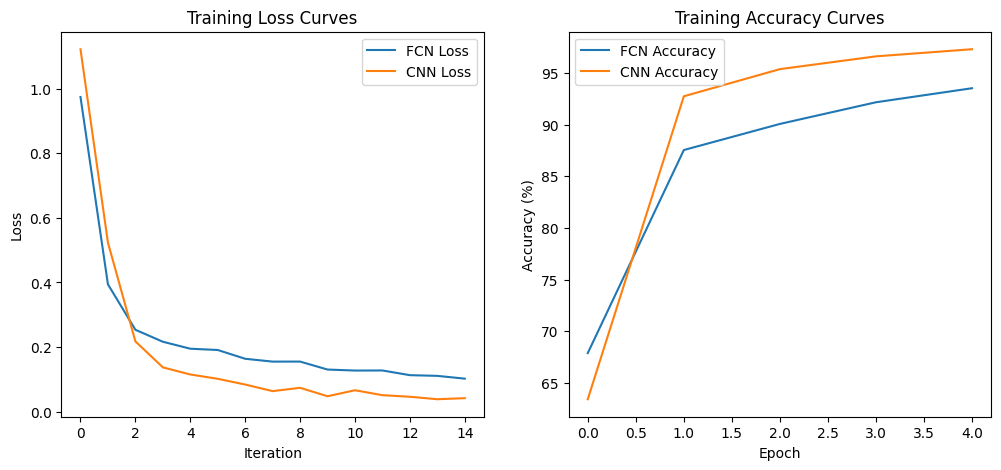

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fcn_losses, label='FCN Loss')
plt.plot(cnn_losses, label='CNN Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fcn_accuracies, label='FCN Accuracy')
plt.plot(cnn_accuracies, label='CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curves')
plt.legend()

plt.show()

#Professor, um adendo. Vou adicionar alguns valores fixos pois não quero perder a lógica realizada pelo senhor e apenas verificar o objetivo de cada pergunta abaixo.

## Exercícios

### Exercício 1
Altere a estrutura da rede e diminua o número de parâmetros na rede FC. O que se observa no resultado do treinamento?

In [22]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 64)   # Menos neurônios na primeira camada
        self.fc2 = nn.Linear(64, 32)        # Menos neurônios na segunda camada
        self.fc3 = nn.Linear(32, 10)        # Camada de saída

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

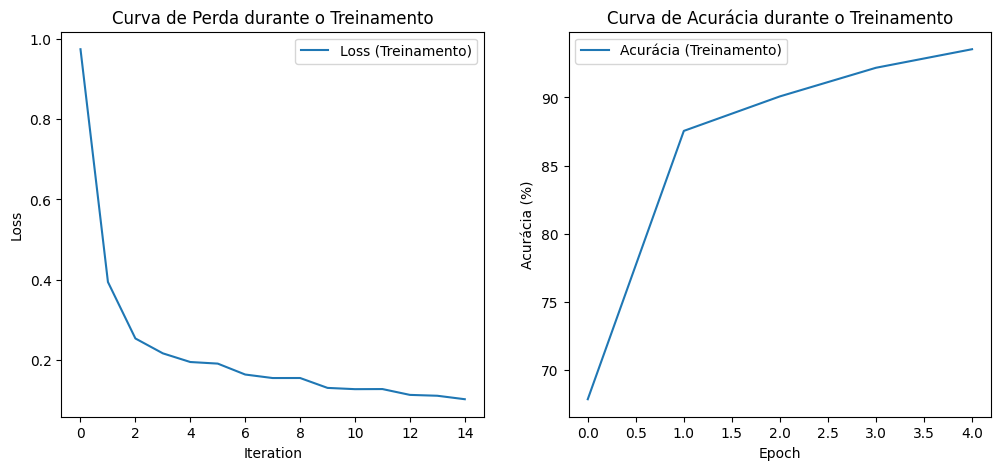

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotar perda
plt.subplot(1, 2, 1)
plt.plot(fcn_losses, label='Loss (Treinamento)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Curva de Perda durante o Treinamento')
plt.legend()

# Plotar acurácia
plt.subplot(1, 2, 2)
plt.plot(fcn_accuracies, label='Acurácia (Treinamento)')
plt.xlabel('Epoch')
plt.ylabel('Acurácia (%)')
plt.title('Curva de Acurácia durante o Treinamento')
plt.legend()

plt.show()


In [24]:
# Testar o modelo no conjunto de teste
def evaluate_on_test_set(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Acurácia do modelo no conjunto de teste: {accuracy:.2f}%')

evaluate_on_test_set(fcn_model, testloader)


Acurácia do modelo no conjunto de teste: 92.40%


### Exercício 2
Aumente o número de filtros convolucionais na CNN. O que se observa no resultado do treinamento em comparação ao anterior? Lembre-se de ajustar os valores das camadas seguintes.

Tempo de Treinamento: Pode aumentar com mais filtros.

Acurácia e Perda: Espera-se melhora na acurácia e redução na perda, mas com o risco potencial de overfitting.

Overfitting: Verifique a diferença entre a acurácia do treinamento e do teste para avaliar o overfitting.


In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)  # Aumenta o número de filtros na primeira camada
        self.conv2 = nn.Conv2d(16, 32, 5) # Aumenta o número de filtros na segunda camada
        # Ajustar o tamanho das camadas lineares conforme o tamanho da saída da camada convolucional
        self.fc1 = nn.Linear(32 * 4 * 4, 128)  # Aumenta o número de neurônios na primeira camada totalmente conectada
        self.fc2 = nn.Linear(128, 10)  # Mantém a camada de saída

    def forward(self, x):
        # Aplicar as camadas convolucionais e max-pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Achatar a saída para as camadas totalmente conectadas
        x = x.view(-1, 32 * 4 * 4)  # Ajuste o tamanho do vetor achatado
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Instanciar o modelo com a nova arquitetura
cnn_model = CNN()

# Contar parâmetros
cnn_params = count_parameters(cnn_model)
print(f"Total de parâmetros na CNN ajustada: {cnn_params}")

# Definir critério e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

# Treinar a CNN ajustada
cnn_losses, cnn_accuracies = train_model(cnn_model, trainloader, criterion, optimizer)


Total de parâmetros na CNN ajustada: 80202


100%|██████████| 157/157 [00:13<00:00, 11.67it/s]


Epoch 1, Loss: 0.152, Accuracy: 72.49%


100%|██████████| 157/157 [00:11<00:00, 14.18it/s]


Epoch 2, Loss: 0.069, Accuracy: 94.41%


100%|██████████| 157/157 [00:15<00:00, 10.32it/s]


Epoch 3, Loss: 0.047, Accuracy: 96.73%


100%|██████████| 157/157 [00:12<00:00, 12.68it/s]


Epoch 4, Loss: 0.044, Accuracy: 97.38%


100%|██████████| 157/157 [00:12<00:00, 12.58it/s]

Epoch 5, Loss: 0.028, Accuracy: 98.09%
Treinamento concluído


100%|██████████| 157/157 [00:12<00:00, 12.69it/s]


Epoch 1, Loss: 0.027, Accuracy: 98.65%


100%|██████████| 157/157 [00:11<00:00, 14.12it/s]


Epoch 2, Loss: 0.022, Accuracy: 98.95%


100%|██████████| 157/157 [00:11<00:00, 13.50it/s]


Epoch 3, Loss: 0.014, Accuracy: 99.12%


100%|██████████| 157/157 [00:11<00:00, 13.21it/s]


Epoch 4, Loss: 0.012, Accuracy: 99.38%


100%|██████████| 157/157 [00:11<00:00, 13.33it/s]


Epoch 5, Loss: 0.011, Accuracy: 99.28%
Treinamento concluído
Acurácia da rede na base de teste: 98.50%
Tempo total de treinamento: 58.84 segundos


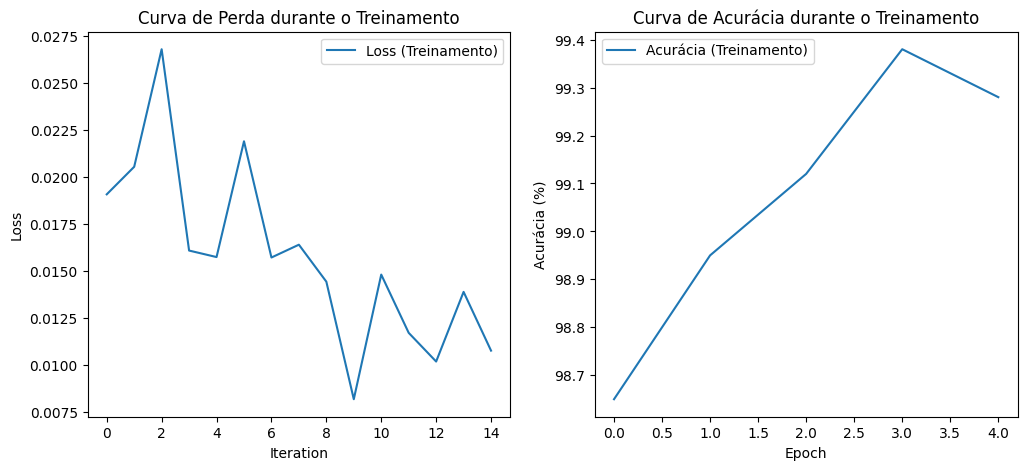

In [27]:
import time

# Medir o tempo de treinamento
start_time = time.time()

# Treinar o modelo ajustado
cnn_losses, cnn_accuracies = train_model(cnn_model, trainloader, criterion, optimizer)

end_time = time.time()
training_time = end_time - start_time

# Testar o modelo
test_model(cnn_model, testloader)

# Imprimir tempo de treinamento
print(f"Tempo total de treinamento: {training_time:.2f} segundos")

# Plotar resultados
plt.figure(figsize=(12, 5))

# Plotar perda
plt.subplot(1, 2, 1)
plt.plot(cnn_losses, label='Loss (Treinamento)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Curva de Perda durante o Treinamento')
plt.legend()

# Plotar acurácia
plt.subplot(1, 2, 2)
plt.plot(cnn_accuracies, label='Acurácia (Treinamento)')
plt.xlabel('Epoch')
plt.ylabel('Acurácia (%)')
plt.title('Curva de Acurácia durante o Treinamento')
plt.legend()

plt.show()


Acurácia:
A acurácia da rede convolucional aumentou para 98.50%, o que é um bom sinal de que a rede está aprendendo melhor com o aumento no número de filtros. Em comparação com a acurácia anterior (98.09%), o aumento é significativo.


Tempo de Treinamento:
O tempo total de treinamento foi de 58.84 segundos. Comparado com o treinamento anterior, pode ter aumentado devido ao aumento no número de filtros e camadas, que tornam a rede mais complexa e exigente computacionalmente.


Desempenho:
O aumento na acurácia sugere que a rede está melhor em capturar características dos dígitos manuscritos com uma configuração de filtros mais complexa. Isso geralmente ocorre porque a rede convolucional pode extrair características mais detalhadas das imagens, ajudando na classificação mais precisa.

Overfitting: Com uma maior acurácia e se a acurácia no conjunto de teste está subindo também, o risco de overfitting pode ser reduzido. No entanto, se o tempo de treinamento e a complexidade aumentarem significativamente, é sempre bom monitorar o desempenho em um conjunto de validação adicional (se disponível) para garantir que o modelo generalize bem e não apenas memorize os dados de treinamento.